In [1]:
# Import your favourite library
import pennylane as qml

# Import Numpy from PennyLane
from pennylane import numpy as np

# Import the library that you need in order to use your IBM account
# import qiskit_ibm_provider

# IBM_token = #'Your Token Goes Here'

# try:
#     qiskit_ibm_provider.IBMProvider()
# except:
#     qiskit_ibm_provider.IBMProvider.save_account(token=IBM_token, overwrite=True)

sample [[0 1]
 [0 1]
 [1 1]
 ...
 [0 0]
 [0 0]
 [1 0]]


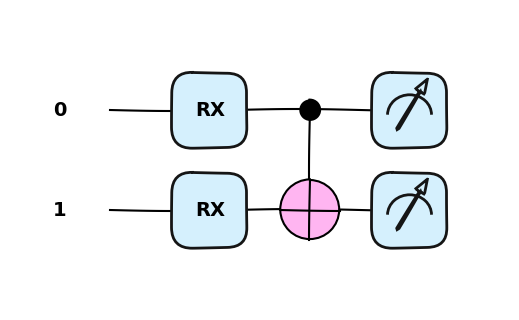

In [2]:
# Choose the device you want to use.
# dev = qml.device("lightning.qubit", wires=2, shots=1000)
dev = qml.device('qiskit.aer', wires=2, shots=1000)
# dev = qml.device('qiskit.ibmq', wires=2, shots=1000, backend='ibmq_qasm_simulator')
# dev = qml.device('qiskit.ibmq', wires=2, shots=1000, backend='ibm_lagos')


# Create a QNode with 2 entangled qubits
@qml.qnode(dev)
def circuit(theta):
    qml.RX(theta[0],wires=0)
    qml.RX(theta[1],wires=1)
    qml.CNOT(wires=[0,1])
    # return qml.expval(qml.PauliZ(wires=range(0,1)))
    return qml.sample()

thetas = np.array([[1.0,2.0],[1.0,2.0]],requires_grad=True)
# Draw your circuit
qml.draw_mpl(circuit,style='pennylane')(thetas)

# Run your circuit
print('sample', np.concatenate(circuit(thetas), axis=0))
# print('sample', circuit(thetas))

In [3]:
def cost(circuit, thetas):
    c = circuit(thetas)
    return np.mean(c)

In [4]:
cost(circuit, thetas)

0.425

In [5]:
opt = qml.GradientDescentOptimizer(0.01)

In [6]:
cost_history = []
for it in range(10):
# for it in range(steps):
    thetas, prev_cost = opt.step_and_cost(lambda thetas: cost(circuit, thetas), thetas)
    
    # clear_output(wait=True)

    print("Step {:3d}       Cost_L = {:9.7f}".format(it, prev_cost), flush=True)
    cost_history.append(prev_cost)

ValueError: shape-mismatch for sum

In [7]:
n_qubits = 3
ancilla_idx = 3

In [8]:
dev = qml.device("lightning.qubit", wires=n_qubits*2, shots=1000)

In [9]:
from problems.toy_problem import *
problem = ToyProblem(
    n_qubits=n_qubits,
)

In [10]:
@qml.qnode(dev)
def hadamard_overlap_test(weights, l=None, lp=None, part=None):
    # H on ancilla index
    qml.Hadamard(ancilla_idx * 2)

    # Variational circuit generating a guess for the solution vector |x> applied to the top half
    problem.variational_block(weights, offset=n_qubits)

    # unitary U_b associated to the problem vector |b> applied to the bottom half
    # In this specific example Adjoint(U_b) = U_b.
    problem.U_b()

    # Controlled application of the unitary component A_l of the problem matrix A on the top half.
    problem.CA(ancilla_idx*2, l, offset=n_qubits)

    # Controlled application of Adjoint(A_lp) applied to the bottom half
    # In this specific example Adjoint(A_lp) = A_lp. #TODO: is it really?
    problem.CA(ancilla_idx*2, lp)

    if part == "Im":
        qml.RZ(phi=-np.pi/2, wires=ancilla_idx*2)

    # CX going from top of top half to top of bottom half, and bottom of top half to bottom of bottom half
    qml.CNOT(wires=(n_qubits*2 - 1, n_qubits-1))
    qml.CNOT(wires=(n_qubits, 0))

    # 3 more hadamards
    qml.Hadamard(wires=n_qubits*2)
    qml.Hadamard(wires=n_qubits*2 - 1)
    qml.Hadamard(wires=n_qubits)

    # to get P(0) - P(1), we only need to measure the expval of the helper qubit
    return qml.expval(qml.PauliZ(wires=ancilla_idx*2))


(<Figure size 900x800 with 1 Axes>, <Axes: >)

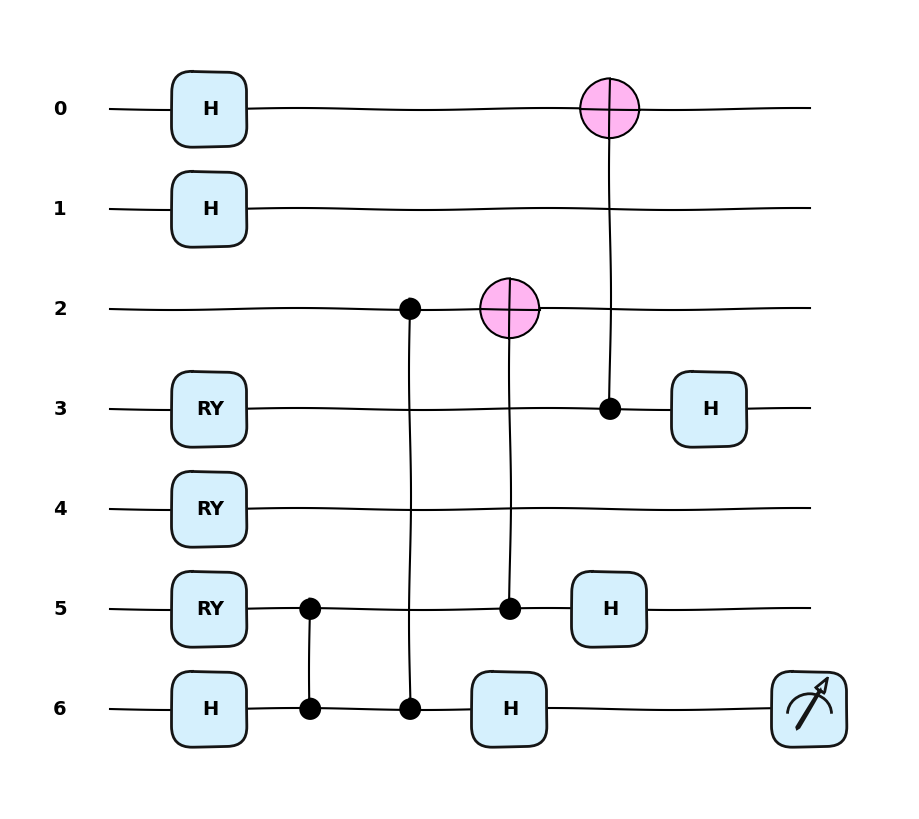

In [12]:
w = 0.001 * np.random.randn(problem.param_shape, requires_grad=True)

qml.draw_mpl(hadamard_overlap_test,style='pennylane')(w, 1, 1, "Re")